# Capstone Project. The Battle of the Neighborhoods (Week 2)

_This notebooks is used for the project within the Courser course 'Applied Data Science Capstone'_<br/>
**It is recommended to run the code in Chrome environment to see the interactive maps.**

## Table of Content

- **[Introduction. The Problem Description](#introduction)**
- **[Data](#data)**
- **[Methodology](#methodology)**
- **[Results](#results)**
- **[Discussion](#discussion)**
- **[Conclusion](#conclusion)**

# Introduction. The Problem Description
<a id='introduction'></a>

In this project we are going to help families with kids to plan their day-off.<br/> 

In big cities, such as Moscow, there are thousands of venues that could be **interesting for families with kids**. But unfortunately parents do not know about them. In fact, there is a very limited list of popular venues mostly placed in the downtown, that are known well to everybody. They are nice but always overcrowded and it could take more than an hour to get there through traffic jams. And parents encounter more problems when they are going to plan several activities for the same day. For example, where they could eat with kids, or what they will do if their plans, weather or mud suddenly change.<br/>

We will use the data science and data visualiziation tools to display on the interactive map **the clustered venues affordable for families with kids**. That clusters will include **venues for education and entertainment** and will be placed in the specified neighbourhood.

# Data
<a id='data'></a>

Taking into acount the problem definition, we will have to mine two types of data:<br/>
>1. We have to determine how to split the Moscow area into neighourhoods with determined geo coordinates;
>2. We have to mine information of venues placed in some specified neighbourhood.

### How to Split the Moscow Area Into Neighbourhoods

There are several ways to determine neighbourhoods in Moscow. The <br/>
For example, it could be done **by the municipalities**. There are 12 administrative districts in Moscow that include 146 municipalities. The list of them that includes their boundaries can be downloaded at http://gis-lab.info/qa/moscow-atd.html in ESRI Shape, GeoJSON, CSV+VRT or KML formats.<br/>
The second way is **by the post offices locations**. There are 13 post regions in Moscow that include 524 post offices. The geo locations of the post offices can be downloaded at http://hubofdata.ru/dataset/ruspost-msk in JSON format.

Using the post offices locations as neighbourhoods centers is easier since we can get their geo coordinates and the most of the venues have postcodes (except such as parks, playgrounds etc). For those that have not, it can be determined by the closest venues. But the size of such neighbourhoods seems to be too small to get a proper point of view.

So, we will **determine the neighbourhoods as the Moscow municipalities.**

Let's download the libraries we'll need

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you run the cell for the first time or in case of error message "Name '...' is not defined"
import folium # map rendering library

!conda install -c conda-forge geopy --yes # uncomment this line if you run the cell for the first time in case of error message "Name '...' is not defined"
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import pandas as pd
import numpy as np

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



Let's download data for Moscow municipalities. The link is http://gis-lab.info/data/mos-adm/mo-csv.zip<br/>
>**Since data are stored in zip file we will need to unzip it first.**

In [2]:
# importing required modules 
from zipfile import ZipFile 

# downloading zip file
!wget -q -O 'mun_coordinates.zip' http://gis-lab.info/data/mos-adm/mo-csv.zip

# specifying the zip file name 
file_name = "mun_coordinates.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip1: 
    # printing all the contents of the zip file 
    zip1.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip1.extractall() 
    print('Done!') 
    
print('Data downloaded!')
mun_coord = pd.read_csv('mo.csv')

File Name                                             Modified             Size
mo.csv                                         2014-06-14 15:29:14       892686
mo.csvt                                        2014-06-14 15:29:14           85
mo.prj                                         2014-06-13 20:27:22          143
mo.qml                                         2014-03-23 21:21:22        10368
mo.vrt                                         2014-03-29 23:06:40          295
Extracting all the files now...
Done!
Data downloaded!


Let's have a look at data we got.

In [3]:
mun_coord.head()

,WKT,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO
0,"MULTIPOLYGON (((36.8031012 55.4408329,36.80319...",Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение
1,"POLYGON ((37.4276499 55.7482092,37.4284863 55....",Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ
2,"POLYGON ((36.8035692 55.4516224,36.8045117 55....",Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение
3,"POLYGON ((36.9372397 55.2413907,36.9372604 55....",Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение
4,"POLYGON ((37.4395575 55.6273129,37.4401803 55....","""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение


It turned out that some columns have information in Cyrillic. To make data more convinient for review within this project we have to **transliterate the Cyrillic symbols into English ones** with similar or alike articulation.<br/>
The cell below makes transliteration by replacing the Cyrillic symbols for the whole 'mo.csv' file.

In [4]:
import os
import fileinput

def latinizator(letter, dic):
    for i, j in dic.items():
        letter = letter.replace(i, j)
    return letter

legend = {
'а':'a',
'б':'b',
'в':'v',
'г':'g',
'д':'d',
'е':'e',
'ё':'yo',
'ж':'zh',
'з':'z',
'и':'i',
'й':'y',
'к':'k',
'л':'l',
'м':'m',
'н':'n',
'о':'o',
'п':'p',
'р':'r',
'с':'s',
'т':'t',
'у':'u',
'ф':'f',
'х':'h',
'ц':'ts',
'ч':'ch',
'ш':'sh',
'щ':'shch',
'ъ':'y',
'ы':'y',
'ь':"'",
'э':'e',
'ю':'yu',
'я':'ya',

'А':'A',
'Б':'B',
'В':'V',
'Г':'G',
'Д':'D',
'Е':'E',
'Ё':'Yo',
'Ж':'Zh',
'З':'Z',
'И':'I',
'Й':'Y',
'К':'K',
'Л':'L',
'М':'M',
'Н':'N',
'О':'O',
'П':'P',
'Р':'R',
'С':'S',
'Т':'T',
'У':'U',
'Ф':'F',
'Х':'H',
'Ц':'Ts',
'Ч':'Ch',
'Ш':'Sh',
'Щ':'Shch',
'Ъ':'Y',
'Ы':'Y',
'Ь':"'",
'Э':'E',
'Ю':'Yu',
'Я':'Ya',
}

with fileinput.FileInput('mo.csv', inplace=True, backup='.bak') as f:
    for line in f:
        print(latinizator(line, legend), end='')

Let's add two new columns for geo coordinates and let's check the result.

In [5]:
mun_coord = pd.read_csv('mo.csv')

# Let's add two columns for centroid information
mun_coord.insert(2,'LAT', 0.0)
mun_coord.insert(3,'LNG', 0.0)
mun_coord['LAT'].astype('float')
mun_coord['LNG'].astype('float')

mun_coord.head()

,WKT,NAME,LAT,LNG,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO
0,"MULTIPOLYGON (((36.8031012 55.4408329,36.80319...",Kievskiy,0.0,0.0,45298555,45945000,Troitskiy,45298000,Troitskiy,Poselenie
1,"POLYGON ((37.4276499 55.7482092,37.4284863 55....",Filyovskiy Park,0.0,0.0,45268595,45328000,Zapadnyy,45268000,ZAO,Munitsipal'nyy okrug
2,"POLYGON ((36.8035692 55.4516224,36.8045117 55....",Novofyodorovskoe,0.0,0.0,45298567,45954000,Troitskiy,45298000,Troitskiy,Poselenie
3,"POLYGON ((36.9372397 55.2413907,36.9372604 55....",Rogovskoe,0.0,0.0,45298575,45956000,Troitskiy,45298000,Troitskiy,Poselenie
4,"POLYGON ((37.4395575 55.6273129,37.4401803 55....","""Mosrentgen""",0.0,0.0,45297568,45953000,Novomoskovskiy,45297000,Novomoskovskiy,Poselenie


#### **So, we have managed to:**<br/>
> - get the list of the Moscow municipalities as our neighbourhoods;
> - get the data about the neigbourhoods boundaries as polygons descriptions;
>> *A polygon description is a list of points that are connected one by one with direct lines. In our case each polygon consists of about 500 and more point. Each point is represented by a couple that is latitude and longitude coordinates separated by space symbol. Since we downloaded .csv file polygon description is in string format;*<br/>
> - replace the Cyrillic symbols in the neighbourhoods data with English ones similar or alike in articulation.

### How to Mine Information of venues placed in some specified neighbourhood

We can do it with **the Foursquare API** and the method called **'explore'**.

With that method we can download the data of venues we are intersted in placed no farther that some specified distance form some specified geo coordinates.

Let's find the geographical coordinates of Moscow

In [6]:
address = 'Moscow'

geolocator = Nominatim(user_agent="ny_explorer")
mos_location = geolocator.geocode(address)

mos_latitude = mos_location.latitude
mos_longitude =mos_location.longitude

print('The geograpical coordinate of Moscow are {}, {}.'.format(mos_latitude, mos_longitude))

The geograpical coordinate of Moscow are 55.7504461, 37.6174943.


Let's make request for FourSquare API. To do it we start with the credentials determination.

In [7]:
CLIENT_ID = 'VC5VAI2CNSBEQ1BIWEREK0RDJX2VK4WVRYEXQTSLB4Q4XXFB' #  Foursquare ID
CLIENT_SECRET = 'HRGWOCZXY555UGMEUD4APX5LYXYTREVQNOLEQZJT1YFRW3U3' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version. In fact, I didn't find the information about it on Foursquare site

print('The credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

The credentails:
CLIENT_ID: VC5VAI2CNSBEQ1BIWEREK0RDJX2VK4WVRYEXQTSLB4Q4XXFB
CLIENT_SECRET:HRGWOCZXY555UGMEUD4APX5LYXYTREVQNOLEQZJT1YFRW3U3


Now we will form the url request for the Foursquare API to download the data of no more that 20 venues in distance no more that 1000 meters from the point determined as Moscow center.

In [8]:
LIMIT = 20 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    mos_latitude, 
    mos_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VC5VAI2CNSBEQ1BIWEREK0RDJX2VK4WVRYEXQTSLB4Q4XXFB&client_secret=HRGWOCZXY555UGMEUD4APX5LYXYTREVQNOLEQZJT1YFRW3U3&v=20180605&ll=55.7504461,37.6174943&radius=1000&limit=20'

We are sending the request and receives the data of venues in json format.

In [9]:
results = requests.get(url).json()

Let's have a look at the data we mined.

In [10]:
results

{'meta': {'code': 200, 'requestId': '5d8e71e5f96b2c00380e3d48'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Khamovniki',
  'headerFullLocation': 'Khamovniki, Moscow',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 209,
  'suggestedBounds': {'ne': {'lat': 55.75944610900001,
    'lng': 37.63345597204126},
   'sw': {'lat': 55.741446090999986, 'lng': 37.60153262795873}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bfbb199565f76b04ccf05db',
       'name': 'The Kremlin (Кремль)',
       'location': {'address': 'Красная пл.',
        'lat': 55.751999,
        'lng': 37.617734,
        'labeledLatLngs': [{'label': 'display',
          'lat': 55.751999,
         

We can see that we got significant amount of data including for those venues we are not interested in, such as boutiques, for example. Of course, we can use this raw data for the following sorting and picking up the venuse affordable for famalies with kids, but in this case we will have to deal with huge data massive and encounter significant computentional resourses needs. Besides, 'explore' method deals with a point coordinates as a center of investigating area, whereas our neighbourhoods are determined by polygon boundaries.

**In fact that means that we have to solve two problems:**<br/>
>1. How to find the center for each of our neighbourhoods if we have just their boundaries as polygons?
>2. How to download from the Foursquare API the data just for venues we are interested in?
<a id='problems'></a>

# Methodology
<a id='methodology'></a>

### How To Find The Center For Each Of Our Neigbourhoods.<br/>
__To do so:__<br/>
- We will transform polygon that is a string into a list of float pairs that represent longitude and latitude.<br/>
- The idea of centroid finding is the following: <br/>
> _Polygon is a set of lines connecting points one by one. We will find the middle of each such line and redraw the polygon by connecting them. That's an iteration procedure. At every iteration polygon will be convoluting around some point that is centroid we are looking for. The indicator of the process called 'gradient' is an averages of longitude and latitude for all points. If after some iteration gradient stayed the same, we can tell that centroid was found. The Picture 1 below illustrates the algorithm._ 

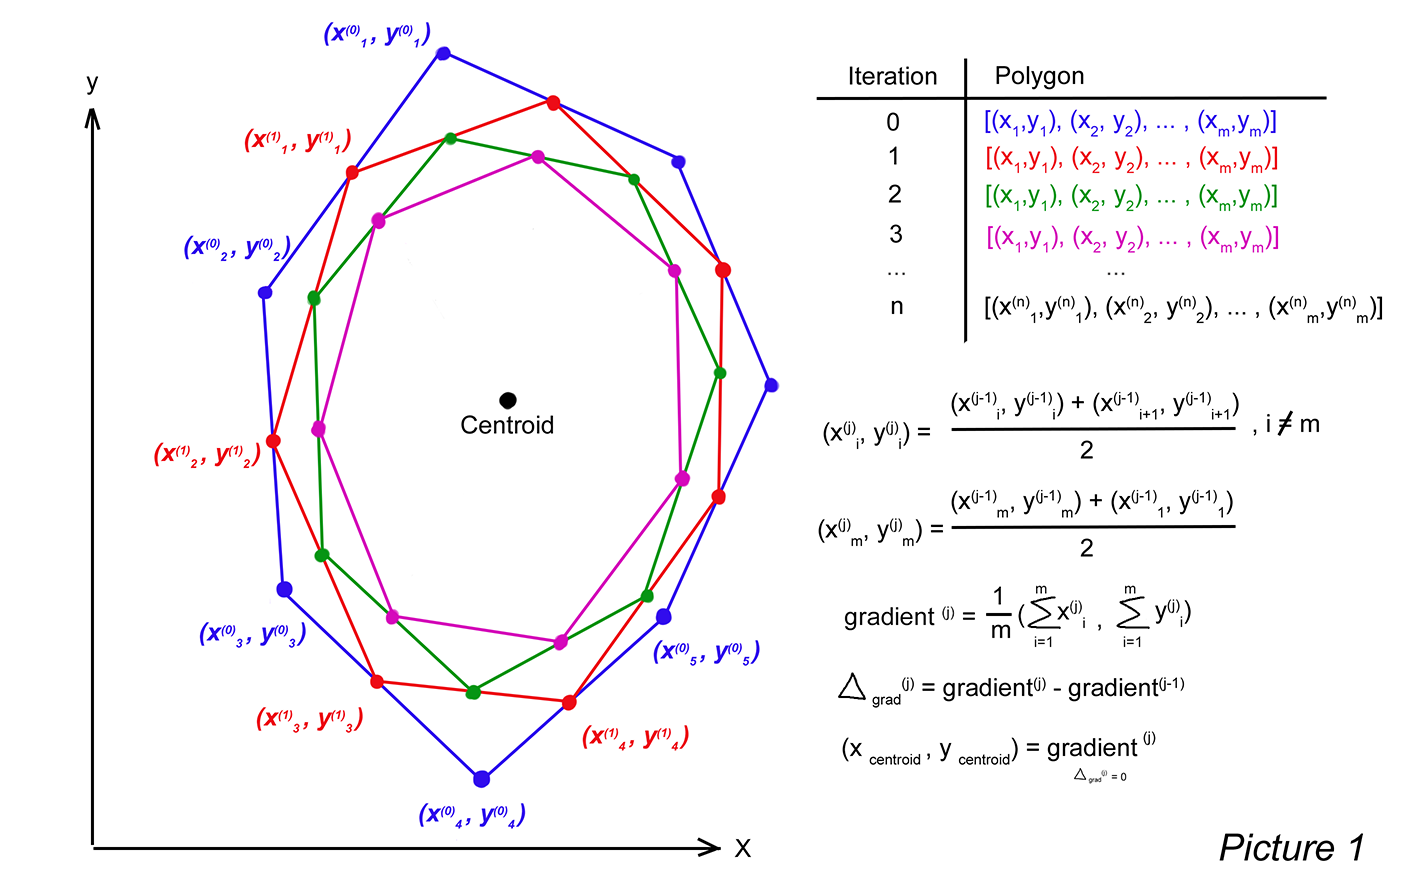

The code for the algorithm described above is in the cell below.<br/>
__Note: This task is rather resource intensive concerning that we have to find centroids for 146 neighbourhoods with 500+ points polygon each.__

In [11]:
m = mun_coord.shape[0]

# Python code to convert string to list with ',' as separator
def Convert(string): 
    li = list(string.split(",")) 
    return li 
 
for i in range(0,m):

    # Convert string into list     
    poly = Convert(mun_coord.iat[i,0])
    p = len(poly)
    
    lat_lng = []
    jj = 0
    # Convert list of strings into array of floats
    for j in range(0,p):
        ll = poly[j]
        if len(ll) == 21 and ll[:1] != '(' and ll[-1:] != ')':
            pol_lng = float(ll[:10])
            pol_lat = float(ll[-10:])
            lat_lng.append([pol_lat, pol_lng])
        
    # Itteration procedure to find cetroid coordinates       
    dll = len(lat_lng)    
    grad_old = [round(sum(row[0] for row in lat_lng)/dll, 7), round(sum(row[1] for row in lat_lng)/dll, 7)]
    grad_new = [0, 0]
    while grad_new != grad_old:
        grad_old = grad_new
        latlng0 = lat_lng[0]
        for ii in range(0,dll):
            if ii != dll-1:
                lat_lng[ii][0] = (lat_lng[ii][0] + lat_lng[ii+1][0]) / 2
                lat_lng[ii][1] = (lat_lng[ii][1] + lat_lng[ii+1][1]) / 2
            else:
                lat_lng[ii][0] = (lat_lng[ii][0] + latlng0[0]) / 2
                lat_lng[ii][1] = (lat_lng[ii][1] + latlng0[1]) / 2
        grad_new = [round(sum(row[0] for row in lat_lng)/dll, 7), round(sum(row[1] for row in lat_lng)/dll, 7)]
        
    # Now we are transferring found cetroid coordinates to dataframe
    mun_coord.iat[i,2] = grad_new[0]
    mun_coord.iat[i,3] = grad_new[1]          

Let's look at the results.

In [12]:
mun_coord.head()

,WKT,NAME,LAT,LNG,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO
0,"MULTIPOLYGON (((36.8031012 55.4408329,36.80319...",Kievskiy,55.383952,36.909133,45298555,45945000,Troitskiy,45298000,Troitskiy,Poselenie
1,"POLYGON ((37.4276499 55.7482092,37.4284863 55....",Filyovskiy Park,55.748470,37.476145,45268595,45328000,Zapadnyy,45268000,ZAO,Munitsipal'nyy okrug
2,"POLYGON ((36.8035692 55.4516224,36.8045117 55....",Novofyodorovskoe,55.420282,36.974195,45298567,45954000,Troitskiy,45298000,Troitskiy,Poselenie
3,"POLYGON ((36.9372397 55.2413907,36.9372604 55....",Rogovskoe,55.228378,37.037273,45298575,45956000,Troitskiy,45298000,Troitskiy,Poselenie
4,"POLYGON ((37.4395575 55.6273129,37.4401803 55....","""Mosrentgen""",55.621927,37.465978,45297568,45953000,Novomoskovskiy,45297000,Novomoskovskiy,Poselenie


Now we have a list of the neighbourhoods with determined coordinates of center for each of them in the columns 'LAT' and 'LNG'. The first of the two [two problems](#problems) is solved.

### How to download from the Foursquare API the data just for venues we are interested in?

Now let us clarify what venue categories we are interested in. To do so we can look through the content by the link https://developer.foursquare.com/docs/resources/categories that includes categories id.<br/>
After looking it through we can determine that we are looking for venues from the categories that could be affordable for families with kids:<br/>

| Venue type | Catergory Id |
|------------|--------------|
| Parks | 4bf58dd8d48988d163941735 |
| Entertaiment centers | 4bf58dd8d48988d1e1931735 |
| Amusement parks | 4bf58dd8d48988d182941735 |
| Playgrounds | 4bf58dd8d48988d1e7941735 |
| Museums | 4bf58dd8d48988d181941735 |
| Cinema | 4bf58dd8d48988d17f941735 |
| Kids cafe | 4bf58dd8d48988d1d0941735 |

**To optimize computational resources we'll pick up venues we are interested in for a neighbourhood called 'Akademichesky'. In fact, it can be any other municipality or current user's location.**<br/>
To do it we have to add to the request url additional parameter describing id of the categories we are looking for.

In [13]:
# Let' pick up the centroid coordinates for 'Akademichesky' neighbourhood
neighbourhood_latitude = mun_coord.iat[76,2]
neighbourhood_longitude = mun_coord.iat[76,3]

# id for catergories we are interested in
cat_id = '4bf58dd8d48988d163941735,4bf58dd8d48988d1e1931735,4bf58dd8d48988d182941735,4bf58dd8d48988d1e7941735,4bf58dd8d48988d181941735,4bf58dd8d48988d17f941735,4bf58dd8d48988d1d0941735' 

Let's arrange that we are going to display no more than 100 venues (parameter 'LIMIT') in the radius 3000 meters from the center of the neighbourhood (parameter 'radius') that is comfortable for half an hour walk.

In [14]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    cat_id, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VC5VAI2CNSBEQ1BIWEREK0RDJX2VK4WVRYEXQTSLB4Q4XXFB&client_secret=HRGWOCZXY555UGMEUD4APX5LYXYTREVQNOLEQZJT1YFRW3U3&v=20180605&ll=55.6901829,37.5789568&categoryId=4bf58dd8d48988d163941735,4bf58dd8d48988d1e1931735,4bf58dd8d48988d182941735,4bf58dd8d48988d1e7941735,4bf58dd8d48988d181941735,4bf58dd8d48988d17f941735,4bf58dd8d48988d1d0941735&radius=3000&limit=100'

We are sending the request and receives data of venues in json format.

In [15]:
results = requests.get(url).json()

Now we are going to transfer the data from json format to dataframe.

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

Let's have a look at the data of venues we mined.

In [18]:
nearby_venues.head(10)

,id,name,categories,lat,lng
0,59a2a8c3c0cacb5d0ff796eb,Академический парк,Park,55.691777,37.568886
1,4e7b0341b0fbf3d6be9917d3,Парк «Новые Черёмушки»,Park,55.693547,37.589786
2,4fb90be5e4b0c86152260256,Двор с фонтаном,Playground,55.692286,37.577203
3,4fbbaa56e4b0c852de6b3a36,Сквер «200 лет А. С. Пушкину»,Park,55.687814,37.575538
4,54ae6d16498e18b8bcce5838,Эндорфин квест,Arcade,55.680578,37.570033
5,4f8c484ee4b0e67b87bb83e1,Аллея,Park,55.678210,37.558306
6,4e527a86d4c075ade75b3f06,Парк Дворца Пионеров,Park,55.702327,37.556238
7,4ed851fcbe7be28335359dac,Молодёжная улица,Park,55.693817,37.546515
8,56d097b7cd10ac3eb8a5d793,Батутный парк «Небо»,Athletics & Sports,55.687681,37.603730
9,57c85b83498eec7de643b658,Kuzina,Dessert Shop,55.688509,37.547529


Let's look at the number of venues we found.

In [19]:
nearby_venues.shape

(84, 5)

The number of the venues found is rather high. So, it will be more convinient to analize them after procedure of clustering.<br/>

## Clustering and Map Compilation Section

Let's look how the found venues of the neighbourhood are distributed on the map.

In [20]:
# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[neighbourhood_latitude, neighbourhood_longitude], zoom_start=12)

# add markers to map
for lat, lng, ven_name, cat in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{}, {}'.format(ven_name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

We see that our venues are distributed into five clusters.To split the venues into clusters we'll use K-Means method to group together the venue situated close to each other.<br/>
This approach will help customer to pick up the most appropriate cluster concerning distance and a set of the venues in it.

The code below is splitting the venue of our dataset into five clusters.

In [21]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# set number of clusters
kclusters = 5

# prepare data for clustering
n_venues = nearby_venues.drop('id', 1)
n_venues = n_venues.drop('name', 1)
n_venues = n_venues.drop('categories', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(n_venues)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:82] 

array([3, 3, 3, 3, 3, 1, 4, 4, 0, 4, 3, 0, 3, 2, 3, 3, 3, 3, 2, 3, 3, 4,
       3, 4, 2, 1, 4, 2, 3, 4, 3, 2, 2, 1, 2, 2, 3, 1, 1, 2, 0, 4, 0, 0,
       0, 2, 0, 4, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 3, 4, 0, 0, 0, 1, 0, 0,
       4, 2, 2, 0, 4, 1, 2, 0, 3, 4, 2, 2, 1, 1, 0, 1], dtype=int32)

In [22]:
# add clustering labels
nearby_venues.insert(0, 'Cluster Labels', kmeans.labels_)

# Results
<a id='results'></a>

To see the results let's show the first ten rows of the dataset.

In [23]:
nearby_venues.head(10)

,Cluster Labels,id,name,categories,lat,lng
0,3,59a2a8c3c0cacb5d0ff796eb,Академический парк,Park,55.691777,37.568886
1,3,4e7b0341b0fbf3d6be9917d3,Парк «Новые Черёмушки»,Park,55.693547,37.589786
2,3,4fb90be5e4b0c86152260256,Двор с фонтаном,Playground,55.692286,37.577203
3,3,4fbbaa56e4b0c852de6b3a36,Сквер «200 лет А. С. Пушкину»,Park,55.687814,37.575538
4,3,54ae6d16498e18b8bcce5838,Эндорфин квест,Arcade,55.680578,37.570033
5,1,4f8c484ee4b0e67b87bb83e1,Аллея,Park,55.678210,37.558306
6,4,4e527a86d4c075ade75b3f06,Парк Дворца Пионеров,Park,55.702327,37.556238
7,4,4ed851fcbe7be28335359dac,Молодёжная улица,Park,55.693817,37.546515
8,0,56d097b7cd10ac3eb8a5d793,Батутный парк «Небо»,Athletics & Sports,55.687681,37.603730
9,4,57c85b83498eec7de643b658,Kuzina,Dessert Shop,55.688509,37.547529


We can see in the list the parks, a trampline venue, a playground, a quest room and a dessert shop.<br/>
>_There is no sense to transliterate the venue names since they remained sensless for English speaking person. For example, 'Батутный парк "Небо" is the trampline park called 'Sky'. Its transliteration will be 'Batutny park "Nebo" and is useless. Some venues in Foursquare (mostly placed in the center of Moscow) has both Russian and English names slashed._ 

Let's look at the list of the venue categories to ensure that all the venue are suitable for families with kids.

In [24]:
cat_venues = nearby_venues
cat_ven = cat_venues.groupby('categories').mean()
cat_ven.index

Index(['Arcade', 'Art Museum', 'Athletics & Sports', 'Cupcake Shop',
       'Dessert Shop', 'Frozen Yogurt Shop', 'Ice Cream Shop', 'Movie Theater',
       'Multiplex', 'Museum', 'Park', 'Pie Shop', 'Playground',
       'Science Museum', 'Shopping Mall', 'Theme Park Ride / Attraction'],
      dtype='object', name='categories')

It looks like all the venues are affordable for families with kids. The 'Shopping Mall' got in the list since there are cimema multiplexes there together with kids' cafe and some attractions.

Let's visualize the results of clustering on the map. We'll also add labels for the venue marks to make the map more convinient.

In [25]:
# create map
map_clusters = folium.Map(location=[neighbourhood_latitude, neighbourhood_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cat, cluster in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories'], nearby_venues['Cluster Labels']):
    label = folium.Popup(name + ', ' + cat + ', Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Discussion
<a id='discussion'></a>

Looking at the map we can see that the most interesting are the clusters 2 and 3 since they are compact. That means that it will be a little more convenient to move from one venue to other by walk.<br/>
Let's make a list of the venues for the clusters 2 and 3 separatly.

**Cluster #2**

In [26]:
cluster2 = nearby_venues.loc[nearby_venues['Cluster Labels'] == 2, ['name', 'categories', 'lat', 'lng']]
cluster2

,name,categories,lat,lng
13,Детская площадка,Playground,55.711351,37.582281
18,Клаустрофобия,Arcade,55.712843,37.596536
24,Prostokvest,Arcade,55.714083,37.571709
27,Детская Площадка,Playground,55.716544,37.586733
31,Донской сквер,Park,55.714075,37.598430
32,CityQuest,Arcade,55.716126,37.572923
34,Neskuchny Garden (Нескучный сад),Park,55.716678,37.586922
35,Сквер у метро Ленинский проспект,Park,55.707312,37.587318
39,Шоколадница,Dessert Shop,55.707768,37.590500
45,Итальянская кондитерская,Dessert Shop,55.711032,37.586948


In [27]:
# the list of categories
cluster2.groupby('categories').sum().index

Index(['Arcade', 'Art Museum', 'Dessert Shop', 'Ice Cream Shop', 'Park',
       'Pie Shop', 'Playground', 'Science Museum'],
      dtype='object', name='categories')

In [28]:
print('Quantity of venues categories in Cluster 2 = ', len(cluster2.groupby('categories').sum().index))

Quantity of venues categories in Cluster 2 =  8


**Cluster #3**

In [29]:
cluster3 = nearby_venues.loc[nearby_venues['Cluster Labels'] == 3, ['name', 'categories', 'lat', 'lng']]
cluster3

,name,categories,lat,lng
0,Академический парк,Park,55.691777,37.568886
1,Парк «Новые Черёмушки»,Park,55.693547,37.589786
2,Двор с фонтаном,Playground,55.692286,37.577203
3,Сквер «200 лет А. С. Пушкину»,Park,55.687814,37.575538
4,Эндорфин квест,Arcade,55.680578,37.570033
10,Сквер на винокурова,Park,55.689456,37.583141
12,детская площадка,Playground,55.686949,37.581865
14,Салют,Movie Theater,55.682933,37.571550
15,Квест Клуб,Arcade,55.687250,37.585670
16,Квест Белый Лебедь,Arcade,55.686636,37.586239


In [30]:
# the list of categories
cluster3.groupby('categories').sum().index

Index(['Arcade', 'Movie Theater', 'Park', 'Playground', 'Science Museum'], dtype='object', name='categories')

In [31]:
print('Quantity of venues categories in Cluster 3 = ', len(cluster3.groupby('categories').sum().index))

Quantity of venues categories in Cluster 3 =  5


So Cluster 2 is more affordable than Cluster 3 since it consists of the venues from more categories (8 vs 5) what means more flexibility and choice for families.

# Conclusion
<a id='conclusion'></a>
We have managed within the project to solve the following problems:<br/>

> 1. We found the way to determine neighbourhoods for Moscow area and dowload corresponding geo data;<br/>
> 2. We transliterated the names of municipalities by replacing Cyrillic symbols with English ones;<br/>
> 3. We developped the algorithm and code for finding geo coordinates of polygon centroids on the base of boundaries polygon by itteration procedure of polygon convolution;<br/>
> 4. We determined the target categories of venues that are affordable for families with kids;<br/>
> 5. We got data of the venues we are interested in through Foursquare API;<br/>
> 6. We clustered the venues according their locations;<br/>
> 7. We displayed the map with marks indicating venues and clusters with pop-up labels;<br/>
> 8. We analize the results and found the most promising and convinient cluster of venues for families with kids.<br/> 